In [ ]:

import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder


file_path = "dataset/imputed_combined_data.parquet" 
df = pd.read_parquet(file_path)

file_path_NANS = "dataset/raw_combined_data.parquet"
df2 = pd.read_parquet(file_path_NANS)

df.head()

max_length = df.groupby("patient_id").size().max()

# Score Calculation
def calculate_sofa(row):
    sofa = 0

    def assign_score(value, thresholds):
        for threshold, score in thresholds:
            if value >= threshold:
                return score
        return 0  

    # Respiration 
    if row.get('FiO2', 0) > 0:
        pao2_fio2 = row.get('SaO2', 0) / row['FiO2']
        sofa += assign_score(pao2_fio2, [(100, 4), (200, 3), (300, 2), (400, 1)])

    # Coagulation
    sofa += assign_score(row.get('Platelets', float('inf')), [(20, 4), (50, 3), (100, 2), (150, 1)])

    # Liver Function
    sofa += assign_score(row.get('Bilirubin_total', 0), [(12, 4), (6, 3), (2, 2), (1.2, 1)])

    # Cardiovascular
    if row.get('MAP', 100) < 70:
        sofa += 1

    # Renal Function
    sofa += assign_score(row.get('Creatinine', 0), [(5, 4), (3.5, 3), (2, 2), (1.2, 1)])

    return sofa

def calculate_news(row):
    news = 0

    def assign_news_score(value, thresholds):
        for threshold, score in thresholds:
            if value >= threshold:
                return score
        return 0  

    # HR (Heart Rate)
    news += assign_news_score(row.get('HR', 0), [(40, 3), (50, 1), (90, 0), (110, 1), (130, 2), (131, 3)])

    # Respiration Rate
    news += assign_news_score(row.get('Resp', 0), [(8, 3), (9, 1), (11, 0), (21, 2), (24, 3)])

    # Temperature
    news += assign_news_score(row.get('Temp', 0), [(35, 3), (36, 1), (38, 1), (39.1, 2)])

    # SBP (Systolic BP) or MAP (Mean Arterial Pressure)
    sbp = row.get('SBP', row.get('MAP', 100))
    news += assign_news_score(sbp, [(90, 3), (100, 2), (110, 1)])

    # O2 Saturation
    news += assign_news_score(row.get('O2Sat', 0), [(85, 3), (91, 2), (93, 1)])

    # Supplemental Oxygen (if available)
    if row.get('FiO2', 0) > 0.21:
        news += 2

    return news

def calculate_qsofa(row):
    qsofa = 0

    # SBP ≤ 100 mmHg
    if row.get('SBP', 120) <= 100:
        qsofa += 1

    # Respiration Rate ≥ 22
    if row.get('Resp', 0) >= 22:
        qsofa += 1

    return qsofa

def num_recorded_values(row):
    recorded_measurements = df.notnull().sum()

    return recorded_measurements

def missingness_feature(row):
    
    if 'ICULOS' and 'ICULOS' in df.columns:
        df = df.sort_values(by='ICULOS')
        time_intervals = df['ICULOS'].diff()

    return time_intervals


def add_temporal_features(df):
    #Adds rolling statistics (moving averages, standard deviation, rate of change) for some features (may or may not be useful).
    time_window_sizes = [3, 6, 12]  # Rolling window sizes (in time steps)
    feature_cols = ['HeartRate', 'RespiratoryRate', 'MAP', 'SpO2', 'Creatinine', 'Platelets']

    df.sort_values(['patient_id', 'ICULOS'], inplace=True)

    for col in feature_cols:
        if col in df.columns:
            for window in time_window_sizes:
                df[f'{col}_MA_{window}h'] = df.groupby('patient_id')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
                df[f'{col}_SD_{window}h'] = df.groupby('patient_id')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
                df[f'{col}_Delta'] = df.groupby('patient_id')[col].diff()
    return df

def preprocess_data(output_file):
    global df 

    df['SOFA'] = df.apply(calculate_sofa, axis=1)
    df['NEWS'] = df.apply(calculate_news, axis=1)
    df['qSOFA'] = df.apply(calculate_qsofa, axis=1)
    #df['num_recorded_values'] = df.apply(num_recorded_values, axis=1)
    #df['missingness_feature'] = df.apply(missingness_feature, axis=1)
    df = add_temporal_features(df)

    if 'Gender' in df.columns:
        df['Gender'] = LabelEncoder().fit_transform(df['Gender'].astype(str))

    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    df.to_parquet(output_file, index=False)

    print(f"Preprocessed data saved to {output_file}")

output_file = "preprocessed_data.parquet"
preprocess_data(output_file)


Preprocessed data saved to preprocessed_data.parquet


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE



os.chdir("/Users/kashishgupta/Documents/DS2025/dl-sepsis-prediction") 
file_path = "preprocessed_data.parquet" 
df = pd.read_parquet(file_path)

# Load dataset
X = df.drop(columns=["SepsisLabel", "patient_id", "dataset", "cluster_id"])
X = X.fillna(method="bfill")
print(X.dtypes)
y = df["SepsisLabel"]


def feature_importance():

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    feature_importance = pd.Series(rf.feature_importances_, index=X.columns)

    plt.figure(figsize=(12, 5))  
    feature_importance.sort_values(ascending=False).plot(kind="bar", color="royalblue")

def rfe():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(model, n_features_to_select=15)  # Select top 15 features
    selector = selector.fit(X, y)

    # Get selected features
    selected_features = X.columns[selector.support_]
    print("Selected Features:", selected_features)

    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)

# Sort features by importance
    feature_ranking = feature_ranking.sort_values()

# Plot the rankings (lower is better)
    plt.figure(figsize=(12, 6))
    plt.barh(feature_ranking.index, feature_ranking.values, color="skyblue")
    plt.xlabel("Feature Rank (Lower = More Important)")
    plt.ylabel("Features")
    plt.title("Feature Importance Ranking Using RFE")
    plt.gca().invert_yaxis()  # Invert so top-ranked features are at the top
    plt.show()


feature_importance()


/var/folders/wb/phhhw5y577vd2cqvhz66d2640000gp/T/ipykernel_3338/4282560675.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="bfill")


HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
                     ...   
Platelets_Delta     float64
Platelets_MA_6h     float64
Platelets_SD_6h     float64
Platelets_MA_12h    float64
Platelets_SD_12h    float64
Length: 63, dtype: object


KeyboardInterrupt: 

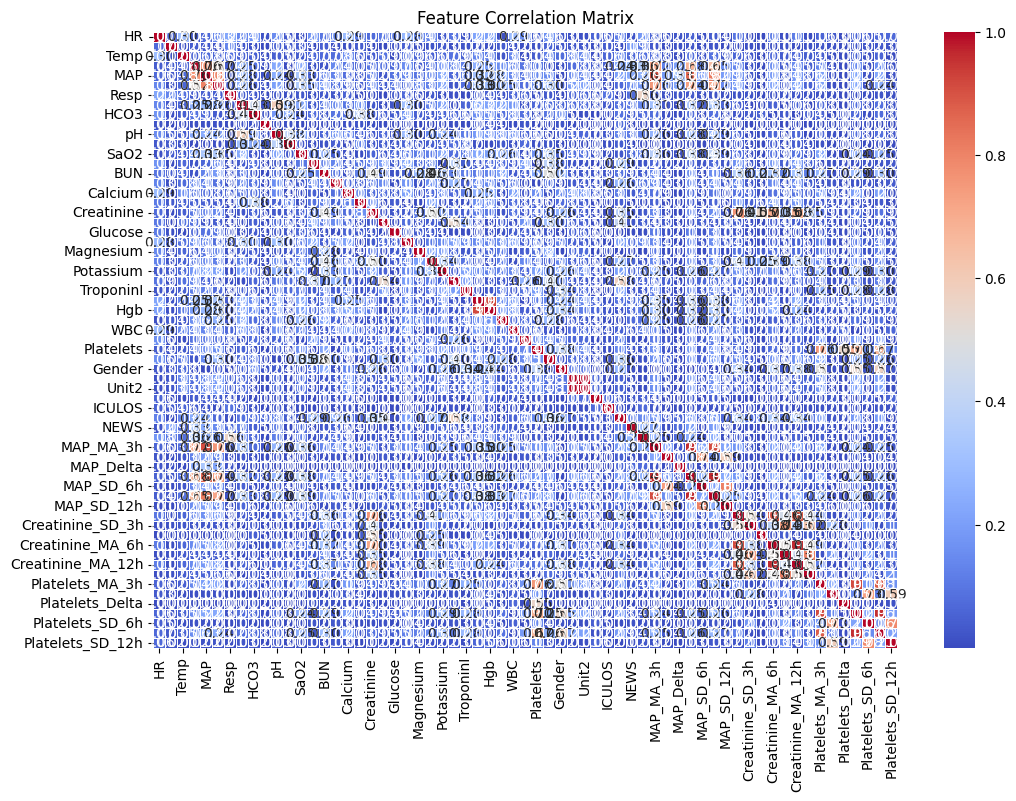

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X.corr().abs()

plt.figure(figsize=(12, 8))  # Set figure size
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

/var/folders/wb/phhhw5y577vd2cqvhz66d2640000gp/T/ipykernel_5162/4174655294.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="bfill")


HR                  0.004411
O2Sat               0.001458
Temp                0.000263
SBP                 0.006689
MAP                 0.003336
                      ...   
Platelets_Delta     0.000070
Platelets_MA_6h     0.000487
Platelets_SD_6h     0.000717
Platelets_MA_12h    0.000454
Platelets_SD_12h    0.000916
Length: 63, dtype: float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
                     ...   
Platelets_Delta     float64
Platelets_MA_6h     float64
Platelets_SD_6h     float64
Platelets_MA_12h    float64
Platelets_SD_12h    float64
Length: 63, dtype: object


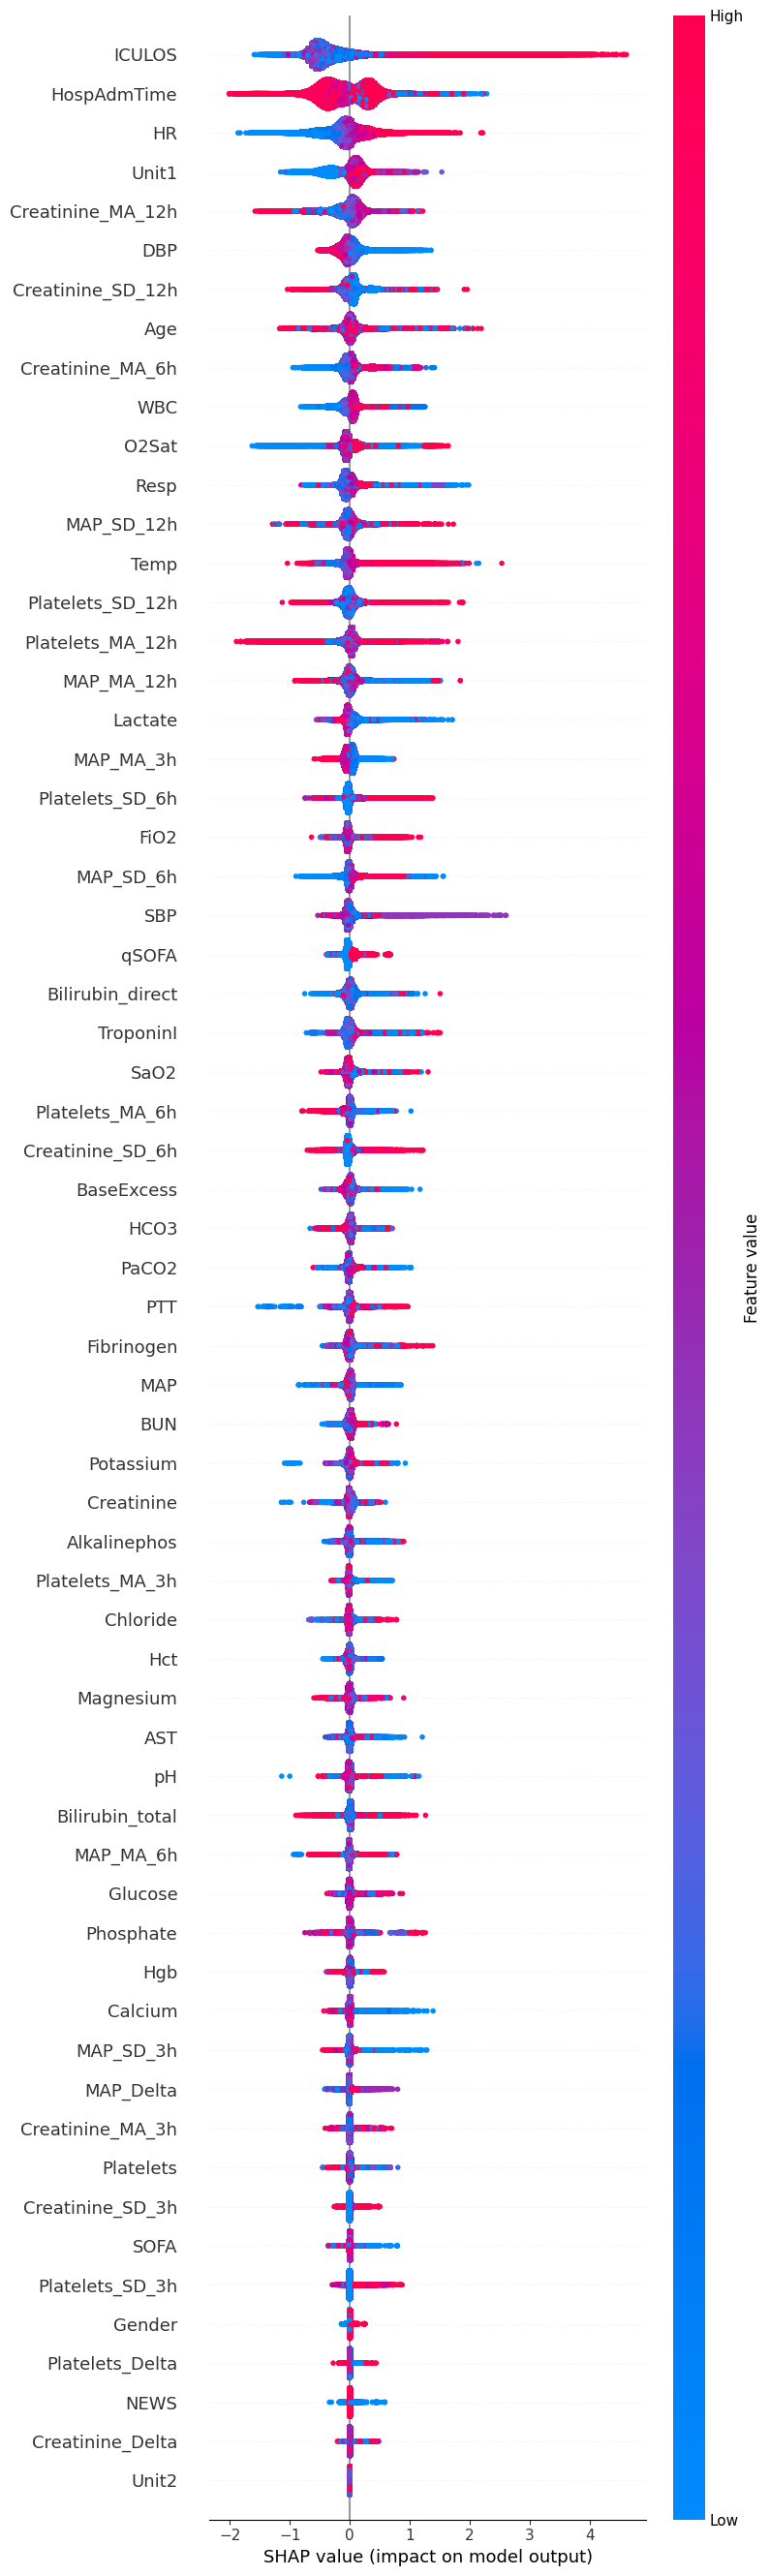

In [14]:
import shap
import xgboost as xgb
import os
import pandas as pd
import numpy as np
import torch


os.chdir("/Users/kashishgupta/Documents/DS2025/dl-sepsis-prediction") 
file_path = "preprocessed_data.parquet" 
df = pd.read_parquet(file_path)

# Load dataset
X = df.drop(columns=["SepsisLabel", "patient_id", "dataset", "cluster_id"])
X = X.fillna(method="bfill")
print(X.var())
print(X.dtypes)
y = df["SepsisLabel"]
# Train XGBoost model

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = xgb.XGBClassifier(n_estimators=100)
model.fit(X_scaled, y)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Explain model predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_scaled)

# Visualize feature importance
shap.summary_plot(shap_values, X_scaled, max_display=X_scaled.shape[1])
%matplotlib inline
plt.show()

Optimal num features code wip

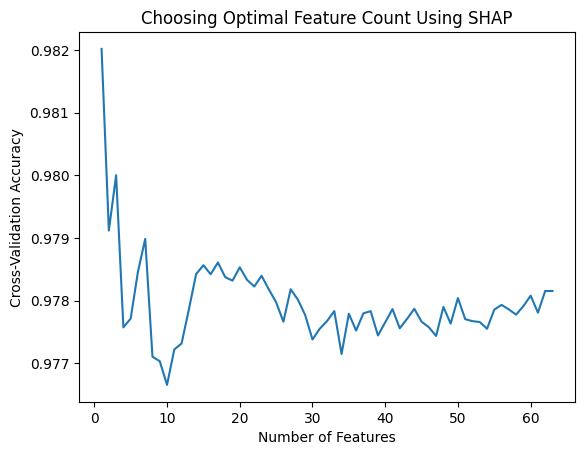

Optimal number of features: 1


In [15]:
from sklearn.model_selection import cross_val_score

shap_importance = np.abs(shap_values.values).mean(axis=0)

# Sort features by importance
sorted_indices = np.argsort(shap_importance)[::-1]  # Descending order
sorted_features = X.columns[sorted_indices]

# Try different feature set sizes
num_features_list = range(1, len(sorted_features) + 1)
scores = []

for num_features in num_features_list:
    selected_X = X[sorted_features[:num_features]]
    score = cross_val_score(model, selected_X, y, cv=5, scoring="accuracy").mean()
    scores.append(score)

# Plot performance vs. number of features
plt.plot(num_features_list, scores)
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Choosing Optimal Feature Count Using SHAP")
plt.show()

# Find optimal number of features where accuracy levels off
optimal_num = num_features_list[np.argmax(scores)]
print(f"Optimal number of features: {optimal_num}")

RUN BELOW FOR FEATURE SELECTION DATASET 

In [ ]:
os.chdir("/Users/kashishgupta/Documents/DS2025/dl-sepsis-prediction") 
file_path = "preprocessed_data.parquet" 
df = pd.read_parquet(file_path)

X = df.drop(columns=["SepsisLabel", "patient_id", "dataset", "cluster_id", "Unit2", "Gender", "Platelets_Delta", "Creatinine_Delta", "Platelets_SD_3h", "Hct", "MAP_Delta", "MAP_SD_3h", "Creatinine_MA_3h", "Creatinine_SD_3h", "Platelets"])
X = X.fillna(method="bfill")
X.to_parquet("feature_selection_preprocessed.parquet", index=False)

RUN BELOW FOR PCA FEATURE REDUCTION DATASET

Original Features: 63, Reduced Features: 42
[[ 1.81253222 -3.46844629  0.10462399 ... -0.20481977  0.32505318
  -0.46114286]
 [ 0.85178968 -3.56601315  0.39724519 ... -0.0581996   0.38013559
  -1.38858171]
 [ 1.39480647 -3.49550993  0.13849338 ... -0.07884624  0.38229711
  -0.73636349]
 ...
 [ 1.61711469 -3.55500296  0.64963038 ...  0.06002319  0.08654519
  -0.78208823]
 [ 2.27622951 -3.48257474  0.53310173 ... -0.1126176   0.34020589
  -0.37055895]
 [ 2.4074676  -3.47093876  0.36935083 ... -0.16404833  0.61967522
  -0.68564831]]


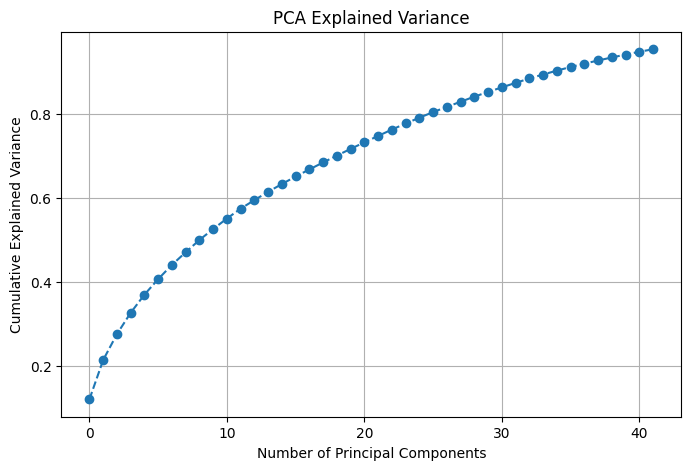

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Check how many components were selected
print(f"Original Features: {X.shape[1]}, Reduced Features: {X_pca.shape[1]}")
print (X_pca)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance_ratio), marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

X_pca_df = pd.DataFrame(X_pca)

# Save the DataFrame as a Parquet file
X_pca_df.to_parquet("pca_preprocessed.parquet", index=False)

